# **Model Building and Training**

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import recall_score, f1_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

## **1. Import Data**

In [2]:
dataset = pd.read_csv("dataset/income.csv")
dataset.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,age_bin,education_bin,hours-per-week_bin
0,39,State-gov,-0.880691,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,37.0,13,39.333333
1,38,Private,0.350346,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,37.0,9,39.333333
2,53,Private,0.520345,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,51.0,7,39.333333
3,28,Private,1.444429,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,26.0,13,39.333333
4,37,Private,0.964715,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K,32.0,14,39.333333


**Feature Selecting**

In [3]:
dataset = dataset.drop(["age_bin", "education_bin", "hours-per-week_bin"], axis= 1)

In [4]:
dataset = dataset.apply(lambda col: pd.factorize(col)[0] if col.dtype == 'object' else col)
dataset.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,0,-0.880691,0,13,0,0,0,0,0,40,0,0
1,38,1,0.350346,1,9,1,1,0,0,0,40,0,0
2,53,1,0.520345,2,7,2,1,1,1,0,40,0,0
3,28,1,1.444429,0,13,2,2,2,1,1,40,1,0
4,37,1,0.964715,3,14,2,3,2,0,1,40,0,0


In [5]:
X = dataset.iloc[:,0:-1]
y = dataset.iloc[:,-1]

## **2. Checking balanced data**

In [6]:
dataset['income'].value_counts(normalize=True)

income
0    0.738198
1    0.261802
Name: proportion, dtype: float64

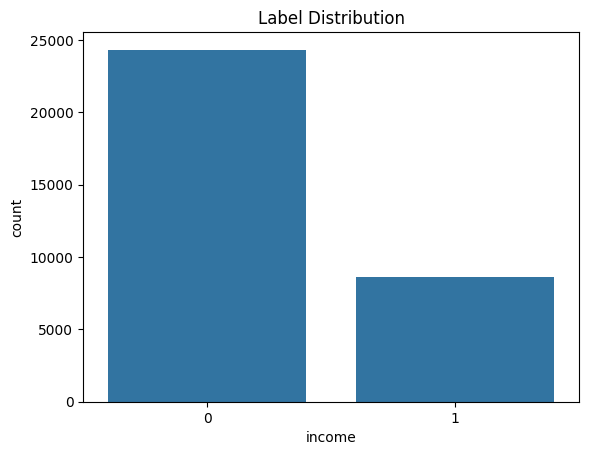

In [7]:
sns.countplot(x='income', data=dataset)
plt.title("Label Distribution")
plt.show()

**Handle it through SMOTE (by generating the random data.)**

In [8]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

## **3. Training and Evaluation**

In [9]:
# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=43)

### **3.1 Building without the Parameter**

In [10]:
def evaluation(model, X_train,y_train,  X_test, y_test):
    # prediction
    y_train_pre = model.predict(X_train)
    y_test_pre = model.predict(X_test)

    # evaluation
    train_f1 = f1_score( y_train,y_train_pre) 
    test_f1 = f1_score(y_test, y_test_pre)
    
    return train_f1, test_f1

In [11]:
# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC()
}

# list is used for storing
results = []

for name, model in models.items():
    
    # trainning
    model.fit(X_train, y_train)
    
    # predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # calculate metric F1-score
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    results.append({
        'Model': name,
        'F1 Train': train_f1,
        'F1 Test': test_f1,
    })

# store results into result_df
result_df1 = pd.DataFrame(results)

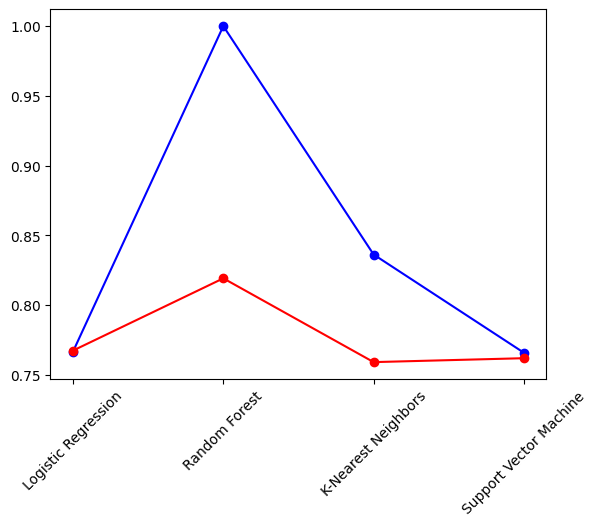

In [12]:
plt.plot(result_df1["Model"], result_df1["F1 Train"], color = "blue", marker= "o", label = "F1 Train")
plt.plot(result_df1["Model"], result_df1["F1 Test"], color = "red",marker= "o", label = "F1 Test")
plt.xticks(rotation=45)

plt.show()

According to the image above, we observed that Most of models are overfitting. 

### **3.2 Building for having Parameter**

**How to resolve this problems ?**

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
import pandas as pd

# models and corresponded params
models_and_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ['l2'],
            "solver": ['lbfgs']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance']
        }
    },
    "Support Vector Machine": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ['linear', 'rbf']
        }
    }
}


In [14]:
models_and_params.keys()

dict_keys(['Logistic Regression', 'Random Forest', 'K-Nearest Neighbors', 'Support Vector Machine'])

In [ ]:

results = []

for name, mp in models_and_params.items():
    grid = GridSearchCV(mp["model"],mp["params"],scoring="f1", cv = 5) # cross validation = 5 
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    
    train_f1, test_f1 = evaluation(best_model,  X_train,y_train,  X_test, y_test)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "F1 Train": train_f1,
        "F1 Test": test_f1
    })
    
# store results into result_df
result_df2 = pd.DataFrame(results)

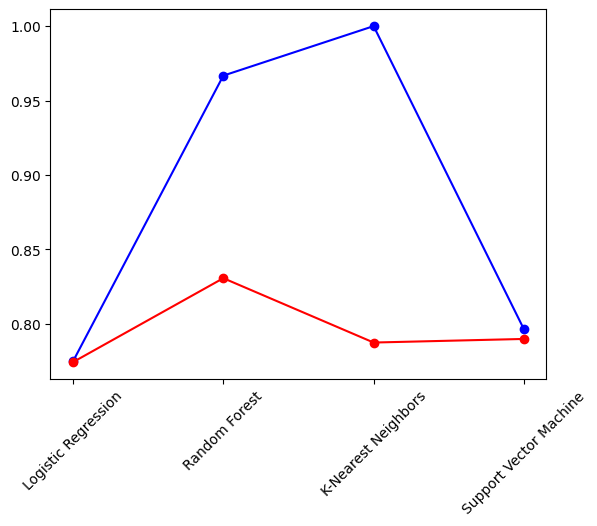

In [ ]:
plt.plot(result_df2["Model"], result_df2["F1 Train"], color = "blue", marker= "o", label = "F1 Train")
plt.plot(result_df2["Model"], result_df2["F1 Test"], color = "red",marker= "o", label = "F1 Test")

plt.xticks(rotation=45)

plt.show()

### **3.3 Handling Overfitting**

#### **3.3.1 Using Regularzation**

**Using L1 (is is known as Lasso), Because of the imbalanced data.**

In [ ]:
# making an effore to reduce overfiting by using regularzation.
logistic_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000)

# trainning
logistic_model.fit(X= X_train, y = y_train)

train_f1, test_f1 = evaluation(logistic_model,  X_train,y_train,  X_test, y_test)

print(f"F1 train:{train_f1}")
print(f"F1 test:{test_f1}")

F1 train:0.7797365362262689
F1 test:0.7767306290988584


**this solution is so bad.**

#### **3.3.2 Adjusting the parameter**

**Using Random Forest seems suitable.**

let's adjust the parameter, I extremly hope that it can resolve the most this problem. 

In [ ]:
parameter = {"n_estimators":[50, 100],
"max_depth": [5,10], # This helps cut off the tree earlier, avoiding fitting to small training details.

 #  Forces a node to have more samples before splitting → prevents over-splitting → stronger tree.
"min_samples_split" :  [int(x) for x in np.linspace(5, 30, 5)],
"min_samples_leaf": [5, 10],

#Limit the number of features considered at each split → makes trees more diverse and less greedy.
 "max_features": ['sqrt', 'log2']   
}
forest_model = RandomForestClassifier()
grid = GridSearchCV(forest_model, parameter, scoring="f1", cv = 4)
grid.fit(X= X_train, y = y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 11, 17, 23, 30],
                         'n_estimators': [50, 100]},
             scoring='f1')

In [ ]:
best_model = grid.best_estimator_

train_f1, test_f1 = evaluation(best_model,  X_train,y_train,  X_test, y_test)

print(f"F1 train:{train_f1}")
print(f"F1 test:{test_f1}")

F1 train:0.8428048545559622
F1 test:0.8221234423959776


**In addition, Using KNN**

In [ ]:
params = {'n_neighbors': [3, 5, 7, 9, 11]}

# building pipeline (Standard + Model)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(params))
])

# Computing learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe,
    X=X_train, y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1
)
